In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import random
import torch
import warnings 
warnings.filterwarnings('ignore')
from pytorch_lightning import seed_everything
import os
import gc
gc.collect()

22

# set_seed(42)

In [2]:
def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
random_state = set_seed(42)

Global seed set to 42


# MADGRAD

In [3]:
import math
from typing import TYPE_CHECKING, Any, Callable, Optional

if TYPE_CHECKING:
    from torch.optim.optimizer import _params_t
else:
    _params_t = Any

class MADGRAD(Optimizer):

    def __init__(
        self, params: _params_t, lr: float = 1e-2, momentum: float = 0.9, weight_decay: float = 0, eps: float = 1e-6,
    ):
        if momentum < 0 or momentum >= 1:
            raise ValueError(f"Momentum {momentum} must be in the range [0,1]")
        if lr <= 0:
            raise ValueError(f"Learning rate {lr} must be positive")
        if weight_decay < 0:
            raise ValueError(f"Weight decay {weight_decay} must be non-negative")
        if eps < 0:
            raise ValueError(f"Eps must be non-negative")

        defaults = dict(lr=lr, eps=eps, momentum=momentum, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self) -> bool:
        return False

    @property
    def supports_flat_params(self) -> bool:
        return True

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:

        loss = None
        if closure is not None:
            loss = closure()

        if 'k' not in self.state:
            self.state['k'] = torch.tensor([0], dtype=torch.long)
        k = self.state['k'].item()

        for group in self.param_groups:
            eps = group["eps"]
            lr = group["lr"] + eps
            decay = group["weight_decay"]
            momentum = group["momentum"]

            ck = 1 - momentum
            lamb = lr * math.pow(k + 1, 0.5)

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if "grad_sum_sq" not in state:
                    state["grad_sum_sq"] = torch.zeros_like(p.data).detach()
                    state["s"] = torch.zeros_like(p.data).detach()
                    if momentum != 0:
                        state["x0"] = torch.clone(p.data).detach()

                if momentum != 0.0 and grad.is_sparse:
                    raise RuntimeError("momentum != 0 is not compatible with sparse gradients")

                grad_sum_sq = state["grad_sum_sq"]
                s = state["s"]

                # Apply weight decay
                if decay != 0:
                    if grad.is_sparse:
                        raise RuntimeError("weight_decay option is not compatible with sparse gradients")

                    grad.add_(p.data, alpha=decay)

                if grad.is_sparse:
                    grad = grad.coalesce()
                    grad_val = grad._values()

                    p_masked = p.sparse_mask(grad)
                    grad_sum_sq_masked = grad_sum_sq.sparse_mask(grad)
                    s_masked = s.sparse_mask(grad)

                    # Compute x_0 from other known quantities
                    rms_masked_vals = grad_sum_sq_masked._values().pow(1 / 3).add_(eps)
                    x0_masked_vals = p_masked._values().addcdiv(s_masked._values(), rms_masked_vals, value=1)

                    # Dense + sparse op
                    grad_sq = grad * grad
                    grad_sum_sq.add_(grad_sq, alpha=lamb)
                    grad_sum_sq_masked.add_(grad_sq, alpha=lamb)

                    rms_masked_vals = grad_sum_sq_masked._values().pow_(1 / 3).add_(eps)

                    s.add_(grad, alpha=lamb)
                    s_masked._values().add_(grad_val, alpha=lamb)

                    # update masked copy of p
                    p_kp1_masked_vals = x0_masked_vals.addcdiv(s_masked._values(), rms_masked_vals, value=-1)
                    # Copy updated masked p to dense p using an add operation
                    p_masked._values().add_(p_kp1_masked_vals, alpha=-1)
                    p.data.add_(p_masked, alpha=-1)
                else:
                    if momentum == 0:
                        # Compute x_0 from other known quantities
                        rms = grad_sum_sq.pow(1 / 3).add_(eps)
                        x0 = p.data.addcdiv(s, rms, value=1)
                    else:
                        x0 = state["x0"]

                    # Accumulate second moments
                    grad_sum_sq.addcmul_(grad, grad, value=lamb)
                    rms = grad_sum_sq.pow(1 / 3).add_(eps)

                    # Update s
                    s.data.add_(grad, alpha=lamb)

                    # Step
                    if momentum == 0:
                        p.data.copy_(x0.addcdiv(s, rms, value=-1))
                    else:
                        z = x0.addcdiv(s, rms, value=-1)

                        # p is a moving average of z
                        p.data.mul_(1 - ck).add_(z, alpha=ck)


        self.state['k'] += 1
        return loss

# LOAD DATA

In [4]:
import os
os.listdir()

['logs',
 'results',
 'submit_0726.csv',
 '全部一起預處理.ipynb',
 '全部集合.txt',
 '全部集合.txt.gz',
 '原始資料整理.ipynb',
 '寶典實驗.ipynb',
 '押匯文件預處理.ipynb',
 '產品bert訓練.ipynb',
 '產品規則加bert.ipynb',
 '產品資料預處理.ipynb',
 '銀行bert訓練.ipynb',
 '銀行規則加bert.ipynb',
 '銀行資料預處理.ipynb',
 '開狀人bert訓練.ipynb',
 '開狀人資料預處理.ipynb']

In [5]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('../data/preprocess_for_SQUAD_產品.csv',index_col=0)[['45A','Y_label','string_Y_1','string_Y_2']].dropna(axis=0)
df.iloc[:,-2:] = df.iloc[:,-2:].astype(int)
df = df.dropna(axis=0)
df = df.reset_index(drop=True)
df = df.rename(columns={'45A':'string_X_train'})
print(df.shape)
train_df, val_df = train_test_split(df,test_size=0.1,random_state=42)
display(train_df.head(100))
display(val_df.head(100))

(3917, 4)


,string_X_train,Y_label,string_Y_1,string_Y_2
720,MALEIC ANHYDRIDE BRIQUETTE TYPE 2000 MT PACKIN...,MALEIC ANHYDRIDE,0,16
3433,EPOXY RESIN 1 RESIN NPEL 128 - QT Y 19200 KGS ...,EPOXY RESIN,0,11
1784,COMMODITY TOTAL QT Y UNIT PRICE ABS AG 12 A 1 ...,PACK,125,129
1741,1 COMMODITY EVA TAISOX 7350 M QUANTITY 100 MT ...,EVA TAISOX 7350,12,27
1910,POLYPROPYLENE RESIN GRADE NO K 1000 CI F CAT L...,POLYPROPYLENE,0,13
...,...,...,...,...
387,EPOXY RESIN 1 NPEL 128 - QT Y 19200 KGS AT USD...,EPOXY RESIN,0,11
30,12 MTS OF OUTS OLE MATERIAL FOR MAKING SHOES E...,EVA TAISOX,45,55
1502,COMMODITY MONO ETHYLENE GLYCOL MEG FIBER GRADE...,MONO ETHYLENE GLYCOL MEG FIBER GRADE,10,46
3709,TERMS OF PRICE CI F ANY PORT IN HO CHI MINH CI...,POLYESTER STAPLE FIBER,92,114


,string_X_train,Y_label,string_Y_1,string_Y_2
270,COMMODITY EVA-7360M QUANTITY 15 MTS UNIT PRICE...,EVA-7360M,10,19
2015,GLASS EPOXY COPPER CLAD LAMINATES 1000 SHEETS ...,COPPER CLAD LAMINATES,12,33
802,CI F HUANGPU OR DONG GUAN PORT CHINA ORCI P IT...,COPPER FOIL,72,83
2899,PROPYLENE COPOLYMER GRADE NO K4650 QUANTITY 19...,PROPYLENE COPOLYMER GRADE NO K4650,0,34
2005,1 CONTRACT NO 21 RTS 030 CARBON FIBER TC 3535 ...,CARBON FIBER,25,37
...,...,...,...,...
3333,DESCRIPTION OF GOODS QUANTITY MT UNIT PRICE US...,PC RESIN,62,70
1185,3200 HIPS RESIN 7500 MT OF PROPYLENE COPOLYMER...,HIPS RESIN,5,15
1905,MALEIC ANHYDRIDE BRIQUETTE TYPE 4000 MT PACKIN...,MALEIC ANHYDRIDE,0,16
1832,COMMODITY ABS AG 15A1 - H Q U A N T I T Y 72 M...,ABS,10,13


In [6]:
for i in tqdm(range(len(df))):
    assert df['Y_label'].values[i] in df['string_X_train'].values[i]

# Model and Tokenizer Initialization

In [7]:
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
gc.collect()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

659

# Data preprocessing

In [8]:
def preprocessing(df):
    contexts = df['string_X_train'].values.tolist()
    questions = [ 'What is the product name?' for i in range(len(df))]
    answers = []
    for idx in df.index:
        answers.append({
            'text':df.loc[idx,'Y_label'],
            'answer_start':df.loc[idx,'string_Y_1'],
            'answer_end':df.loc[idx,'string_Y_2'],
            })
    return contexts ,questions ,answers

train_contexts ,train_questions ,train_answers = preprocessing(train_df)
val_contexts ,val_questions ,val_answers = preprocessing(val_df)
gc.collect()

0

# tokenize our context/question pairs

In [9]:
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)
gc.collect()

0

# add_token_positions

In [10]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)
gc.collect()

0

# data is ready put it in a PyTorch dataset

In [11]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)
gc.collect()

467

# train loop

In [12]:
from torch.utils.data import DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model.to(device)
model.train()
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 8, shuffle=True)
optimizer = MADGRAD(model.parameters(),lr=5e-5)
gc.collect()

def train_step(model,batch,optimizer):
    model = model.to(device)
    model.train()
    # forward
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    
    # update model
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    gc.collect()
    return loss.item()

def val_step(model,batch,optimizer):
    model = model.to(device)
    model.eval()
    # forward
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    
    gc.collect()
    return loss.item()

def train_loop(model,train_loader,val_loader,optimizer,max_epochs=5,patience=3):
    history = {'train_loss':[],'val_loss':[]}
    best_loss = np.inf
    best_model = None
    not_improve_count = 0
    for epoch in tqdm(range(max_epochs)):    
        # reset this epoch loss equal to zero
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0

        # train one epoch and get train_loss
        for i,batch in enumerate(tqdm(train_loader)):
            epoch_train_loss += train_step(model,batch,optimizer)

        # val one epoch and get val_loss
        for j,batch in enumerate(tqdm(val_loader)):
            epoch_val_loss += val_step(model,batch,optimizer)

        # record loss history
        history['train_loss'].append(epoch_train_loss/i)
        history['val_loss'].append(epoch_val_loss/j)

        # print this epoch's infomation
        print(f'epoch:{epoch} train_loss:{epoch_train_loss/i} val_loss:{epoch_val_loss/j}')

        # save best_model (if current val_loss <= best_loss)
        if history['val_loss'][-1] <= best_loss: 
            best_model = deepcopy(model.eval())
            best_loss = history['val_loss'][-1]
            print(f'save best_model now_val_best_loss is:{best_loss}')

        if history['val_loss'][-1] > best_loss:
            not_improve_count += 1
            print(f'not_improve_count:{not_improve_count}')
            if not_improve_count > patience:
                print('early_stoping')
                break

    # GET best_model.eval()
    model = best_model.eval()
    return model,history

cuda


In [13]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
model,history = train_loop(model,train_loader,val_loader,optimizer,max_epochs=5*3,patience=3)


epoch:0 train_loss:0.9920483099042692 val_loss:0.4482837750886877
save best_model now_val_best_loss is:0.4482837750886877



epoch:1 train_loss:0.5059715718030929 val_loss:0.37794329575262964
save best_model now_val_best_loss is:0.37794329575262964



epoch:2 train_loss:0.6280302997424522 val_loss:0.5046763777500018
not_improve_count:1



epoch:3 train_loss:0.49086925006175247 val_loss:0.5410198675623784
not_improve_count:2



epoch:4 train_loss:0.3584586537421935 val_loss:0.2857191044992457
save best_model now_val_best_loss is:0.2857191044992457



epoch:5 train_loss:0.2567974023129368 val_loss:0.3133658676330621
not_improve_count:3



epoch:6 train_loss:0.18664117929243235 val_loss:0.3383412532663594
not_improve_count:4
early_stoping



# loss curve

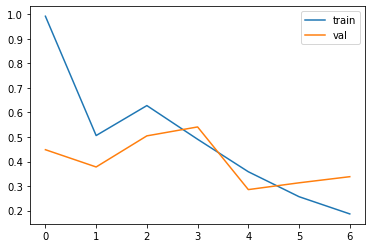

In [23]:
plt.plot(history['train_loss'],label='train')
plt.plot(history['val_loss'],label='val')
plt.legend()
plt.show()

# question-answering pipeline

In [24]:
from transformers import pipeline
nlp = pipeline('question-answering', model=model.to('cpu'), tokenizer=tokenizer)

# test

In [25]:
def test_model(df):
    table = pd.DataFrame()
    for i in tqdm(df.index):
        sample = df.loc[[i]]
        string_X_train = sample['string_X_train'].values[0]
        string_Y_1 = sample['string_Y_1'].values[0]
        string_Y_2 = sample['string_Y_2'].values[0]
        QA_input = {
            'question': 'What is the product name?',
            'context': string_X_train
        }
        res = nlp(QA_input)
        predict = QA_input['context'][res['start']:res['end']]
        row = pd.DataFrame({
            'label':string_X_train[string_Y_1:string_Y_2],
            'predict:':predict},index=[i])
        if string_X_train[string_Y_1:string_Y_2] == predict:
            row['是否全對'] = 'Yes'
        else:
            row['是否全對'] = 'No'
        table = table.append(row)
        i += 1
    return table

# 最後讓我們來看看模型在驗證集上的表現

In [26]:
all_res = test_model(val_df.sample(50))
all_res

,label,predict:,是否全對
3586,DINP,DEHP,No
1822,COPPER FOIL,COPPER FOIL,Yes
3027,TAIRILIN BRAND POLYESTER FILM B GRADE,TAIRILIN BRAND POLYESTER FILM B GRADE,Yes
1615,TAIRIREX POLYSTYRENE,TAIRIREX POLYSTYRENE,Yes
438,EVA TAISOX 7350,EVA TAISOX,No
3857,PVC RESIN S-60,PVC RESIN S-60,Yes
457,BASE OIL 500N,BASE OIL 500N,Yes
2405,ABS RESIN,ABS RESIN,Yes
2528,TETRA HYDRO PHTHALIC ANHYDRIDE,TETRA HYDRO PHTHALIC ANHYDRIDE THPA,No
2475,ABS,ABS,Yes


In [27]:
all_res[all_res['是否全對']=='No']

,label,predict:,是否全對
3586,DINP,DEHP,No
438,EVA TAISOX 7350,EVA TAISOX,No
2528,TETRA HYDRO PHTHALIC ANHYDRIDE,TETRA HYDRO PHTHALIC ANHYDRIDE THPA,No
2154,PA,SPAIN,No
1924,TAIRILIN BRAND POLYESTER FILM B GRADE 11-13MICRON,POLYESTER FILM B GRADE 11-13MICRON,No
1450,SAN RESIN,ABS RESINS,No
32,RESIN,PVC MASS RESIN,No
2682,GLASS EPOXY PREPREG,COPPER CLAD LAMINATE,No
2221,ABS RESIN GRADE NO AG20GF,ABS RESIN,No
174,PVC MASS RESIN B-57,PVC MASS RESIN,No


# claculate acc and jaccard

In [28]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

display(all_res['是否全對'].value_counts())
acc = all_res['是否全對'].value_counts()['Yes']/len(all_res)
print('acc:',acc)
jaccard_avg_score = np.mean([ get_jaccard_sim(all_res.label.loc[i],all_res['predict:'].loc[i]) for i in all_res.index])
print('jaccard_avg_score:',jaccard_avg_score)

Yes    39
No     11
Name: 是否全對, dtype: int64

acc: 0.78
jaccard_avg_score: 0.8652857142857142


# claculate 放水acc

In [29]:
def get_acc2(df):
    correct = []
    correct_label = []
    df['predict:'] = [[i] for i in df['predict:']]
    for i in df.index:
        jacs = []
        for j in df.loc[i,'predict:']:
            jacs.append(get_jaccard_sim(df.loc[i,'label'],j))
        if max(jacs) >= 0.75:
            correct.append('yes')
        else:
            correct.append('no')
    return correct

In [30]:
a = pd.Series(get_acc2(all_res.sample(50)))
a.value_counts()['yes']/len(a)

0.82

In [31]:
torch.save(model.state_dict(),'../models/Product_Data_SQuAD_model_產品.pt')